In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import geopandas as gpd
from shapely.geometry import Point
from functions import *
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
rent = pd.read_csv('Data/Raw/zillow_data.csv')
rent = rent[rent.City=='New York']
rent.drop(['RegionID', 'SizeRank', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName'], axis=1, inplace=True)


In [3]:
# group by year and get average

df = rent.melt(id_vars='RegionName',var_name='year',value_name='med_rent')
df['year'] = pd.to_datetime(df['year']).dt.year
df = df.groupby(['RegionName','year'])['med_rent'].mean().reset_index()  # get the average of that year for that zipcode
df.RegionName = df.RegionName.astype(str)
df['year'] = pd.to_datetime(df['year'].astype(str))
df


,RegionName,year,med_rent
0,10001,2015-01-01,4040.470666
1,10001,2016-01-01,4064.985738
2,10001,2017-01-01,3988.051662
3,10001,2018-01-01,4043.817517
4,10001,2019-01-01,4194.208708
...,...,...,...
1455,11694,2020-01-01,NaN
1456,11694,2021-01-01,NaN
1457,11694,2022-01-01,NaN
1458,11694,2023-01-01,NaN


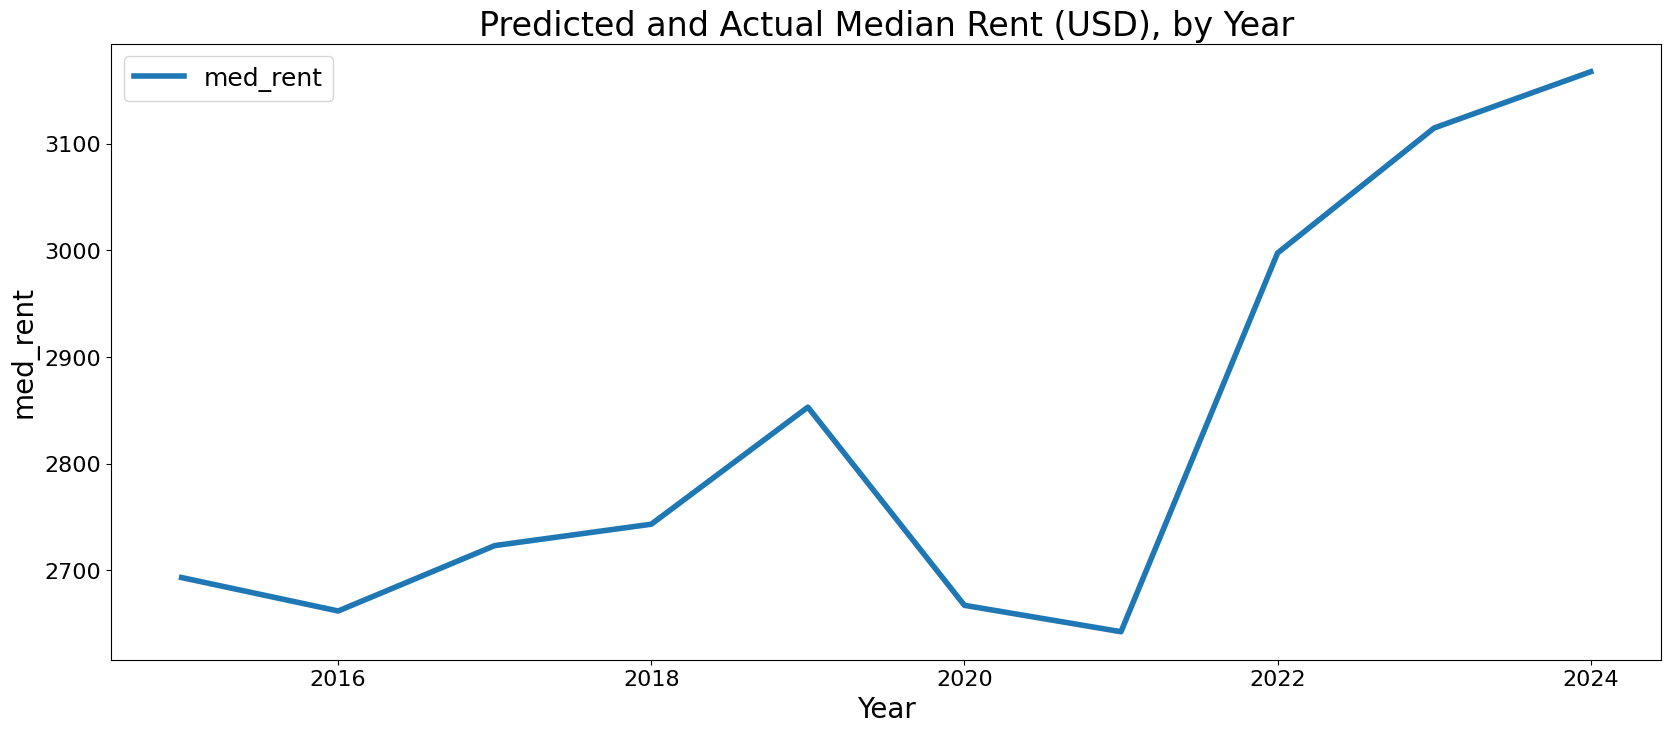

In [4]:
# check distribution of data before imputing 

group_by_yr = df.groupby('year')['med_rent'].mean().reset_index()
group_by_yr['year'] = group_by_yr['year'].dt.year
lineplot(group_by_yr, ['med_rent'], title="Predicted and Actual Median Rent (USD), by Year")

### Add Missing years 

In [5]:
# expand date range to 2010

full_date_range = pd.date_range(start='2010-01-01', end='2024-01-01', freq='YS')
more_yrs = df.groupby('RegionName')[['year','med_rent']].apply(lambda x: x.set_index('year').reindex(full_date_range))
more_yrs = more_yrs.reset_index().rename(columns={'level_1':'year'})
more_yrs = more_yrs.sort_values(['RegionName','year'])
more_yrs

,RegionName,year,med_rent
0,10001,2010-01-01,NaN
1,10001,2011-01-01,NaN
2,10001,2012-01-01,NaN
3,10001,2013-01-01,NaN
4,10001,2014-01-01,NaN
...,...,...,...
2185,11694,2020-01-01,NaN
2186,11694,2021-01-01,NaN
2187,11694,2022-01-01,NaN
2188,11694,2023-01-01,NaN


## Linear Interpolation

In [6]:
def backfill_trend(df, column, exponential=False):
    non_null_values = df[column].dropna()
    if len(non_null_values) < 5:  # if there aren't enough observations to make a trend, will rely in spatial interpolation in postprocessing
        return df

    first_valid_index = non_null_values.index[0]
    valid_indices = np.arange(len(df))
    valid_values = df[column].values
    
    # Prepare data for linear regression
    known_indices = np.where(~np.isnan(valid_values))[0].reshape(-1, 1)
    known_values = valid_values[~np.isnan(valid_values)]

    model = LinearRegression()
    if exponential:
        model.fit(known_indices, np.log(known_values))  # take the log to make the exponential data linear
    else:
        model.fit(known_indices, known_values)
    
    missing_indices = np.where(np.isnan(valid_values))[0].reshape(-1, 1)
    predicted_values = model.predict(missing_indices)

    if exponential:
        predicted_values = np.exp(predicted_values)  # reshape the preds to make them exponentially shaped again
    
    # Assign backfilled values
    df[column].iloc[missing_indices.flatten()] = predicted_values
    
    return df

### Validate Backfill Function

In [7]:
val = more_yrs.copy()
val = val[val.year>'2014']

# split features and labels
labels = val[val.year>'2020']

# remove zip codes without enough data
to_drop = labels[labels.med_rent.isna()]['RegionName'].unique()
labels = labels[labels.RegionName.isin(to_drop)==False]
val = val[val.RegionName.isin(to_drop)==False]

# replace labels with nans 
val.loc[labels.index, 'med_rent'] = np.nan

# apply regression for the missing vals
val_exp = val.copy()
val_exp.rename(columns={'med_rent':'preds_exponential'}, inplace=True)
val_lin = val.copy()
val_lin.rename(columns={'med_rent':'preds_linear'}, inplace=True)
for zipcode in val_exp['RegionName'].unique():
    zip_df = val_exp[val_exp['RegionName']==zipcode]
    val_exp.drop(zip_df.index, inplace=True)
    zip_df = backfill_trend(zip_df, 'preds_exponential', exponential=True)
    val_exp = pd.concat([val_exp, zip_df])
for zipcode in val_lin['RegionName'].unique():
    zip_df = val_lin[val_lin['RegionName']==zipcode]
    val_lin.drop(zip_df.index, inplace=True)
    zip_df = backfill_trend(zip_df, 'preds_linear', exponential=False)
    val_lin = pd.concat([val_lin, zip_df])

# compare predictions with groundtruth
preds = pd.concat([val_exp, val_lin['preds_linear']], axis=1)
preds = preds.merge(labels, on=['RegionName','year'])
preds = preds[preds.year>'2020']
preds.drop(preds[preds.preds_linear.isnull()].index, inplace=True)

# compute baseline: mean rent annually
avg_rent = more_yrs.groupby('year')['med_rent'].mean()
avg_rent.name='annual_avg_rent'
preds = preds.merge(avg_rent, on='year')
preds

,RegionName,year,preds_exponential,preds_linear,med_rent,annual_avg_rent
0,10001,2021-01-01,4002.929184,4006.014522,4095.062903,2642.220480
1,10001,2022-01-01,3993.559446,3997.184848,4885.848383,2997.586674
2,10001,2023-01-01,3984.211640,3988.355175,5001.523985,3114.899929
3,10001,2024-01-01,3974.885714,3979.525501,5131.751891,3167.701829
4,10002,2021-01-01,3392.321134,3392.437927,3286.152608,2642.220480
...,...,...,...,...,...,...
283,11385,2024-01-01,2568.290003,2559.471169,3053.178462,3167.701829
284,11432,2021-01-01,1945.004635,1928.706445,1914.018286,2642.220480
285,11432,2022-01-01,2042.636379,2010.450860,2025.043963,2997.586674
286,11432,2023-01-01,2145.168859,2092.195275,2189.091778,3114.899929


In [14]:
preds[preds.RegionName=='10040']

,RegionName,year,preds_exponential,preds_linear,med_rent,annual_avg_rent
124,10040,2021-01-01,2086.590867,2078.485787,1952.452752,2642.220480
125,10040,2022-01-01,2144.270780,2129.820221,2177.073288,2997.586674
126,10040,2023-01-01,2203.545148,2181.154655,2304.896790,3114.899929
127,10040,2024-01-01,2264.458045,2232.489089,2389.726983,3167.701829


In [12]:
# calculate errors
cols = ['preds_exponential', 'preds_linear', 'annual_avg_rent']
for col in cols:
    print(f'RMSE {col}:\n   ',root_mean_squared_error(preds[col], preds['med_rent']))


RMSE preds_exponential:
    482.0821885654433
RMSE preds_linear:
    487.1504192377298
RMSE annual_avg_rent:
    856.9101048512991


### Apply backfill function

In [54]:
for zipcode in more_yrs['RegionName'].unique():
    zip_df = more_yrs[more_yrs['RegionName']==zipcode]
    more_yrs.drop(zip_df.index, inplace=True)
    zip_df = backfill_trend(zip_df, 'med_rent', exponential=True)
    more_yrs = pd.concat([more_yrs, zip_df])
more_yrs

,RegionName,year,med_rent
0,10001,2010-01-01,3311.915852
1,10001,2011-01-01,3405.150436
2,10001,2012-01-01,3501.009690
3,10001,2013-01-01,3599.567502
4,10001,2014-01-01,3700.899841
...,...,...,...
2185,11694,2020-01-01,NaN
2186,11694,2021-01-01,NaN
2187,11694,2022-01-01,NaN
2188,11694,2023-01-01,NaN


### Match Zip Codes to CT's  

In [55]:
# get census tract to ZCTA conversion

# Load the shapefiles
tracts = gpd.read_file('Data/Raw/tracts2020_shapefile/nyct2020.shp')
tracts = tracts.to_crs(epsg = 4326)
zips = gpd.read_file('Data/Raw/zcta2020_shapefile/tl_2020_us_zcta520.shp')
zips = zips.to_crs(epsg = 4326)

# join files together on intersecion
mapping = gpd.sjoin(zips, tracts, how='inner', predicate="intersects")[['ZCTA5CE20','GEOID']]
mapping

# add census tract to main dataframe
merged = more_yrs.merge(mapping, left_on='RegionName', right_on='ZCTA5CE20', how='left').drop(['ZCTA5CE20'],axis=1)

In [56]:
# remove 2024
merged['year'] = pd.to_datetime(merged['year']).dt.year
dff = merged[merged.year.isin([2024])==False]
dff.sort_values('RegionName', inplace=True)
dff.drop_duplicates(['year','GEOID'], inplace=True)  # same zip code is matching with multiple CT's so we drop dupes randomly


In [57]:
# adjust dtype
dff.drop('RegionName', axis=1, inplace=True)
dff['year'] = dff['year'].astype(str)
dff

,year,med_rent,GEOID
0,2010,3311.915852,36061005600
160,2018,4043.817517,36061011700
161,2018,4043.817517,36061008200
162,2019,4194.208708,36061005600
163,2019,4194.208708,36061005800
...,...,...,...
55282,2014,NaN,36081093800
55283,2014,NaN,36081094201
55284,2014,NaN,36081094202
55277,2014,NaN,36081092200


In [69]:
# dff.to_parquet('Data/Cleaned/zillow_clean.parquet')

### Inspect a Specific Case Before/After Interpolation

In [83]:
def lineplot(df, features, title=None):
    ''' Parameters
        ----------
        df : Pandas dataframe
        features: list
            one or more features to be plotted
        title: str, optional
            title for chart
        
        Yields
        -------
        matplotlib object
            One or more overlayed lineplots'''
    
    
    plt.figure(figsize=(20, 8));
    for feat in features:
        # x = df.groupby("year")[feat].mean().reset_index().dropna()
        # y = (x[feat] - min(x[feat])) / (max(x[feat]) - min(x[feat]))
        y = df[feat]
        ax= sns.lineplot(x=df['year'].astype(int), y= y, hue=df['Category'], linewidth = 4, palette=['green','blue'])
    ax.set_title(title, fontsize=24);
    ax.set_ylabel(feat, fontsize=20);
    ax.set_xlabel('Year', fontsize=20);
    ax.legend(prop=dict(size=18));
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);

In [53]:
dff[dff.GEOID=='36061011700'].sort_values('year')

,year,med_rent,GEOID
16,2010,NaN,36061011700
34,2011,NaN,36061011700
52,2012,NaN,36061011700
70,2013,NaN,36061011700
88,2014,NaN,36061011700
106,2015,4040.470666,36061011700
124,2016,4064.985738,36061011700
142,2017,3988.051662,36061011700
160,2018,4043.817517,36061011700
178,2019,4194.208708,36061011700


In [80]:
# dff['year']  = pd.to_datetime(dff['year']).dt.year
dff[dff.GEOID=='36061011700'].sort_values('year')

,year,med_rent,GEOID,Category
16,2010,3311.915852,36061011700,Predicted
34,2011,3405.150436,36061011700,Predicted
52,2012,3501.009690,36061011700,Predicted
70,2013,3599.567502,36061011700,Predicted
88,2014,3700.899841,36061011700,Predicted
106,2015,4040.470666,36061011700,Actual
124,2016,4064.985738,36061011700,Actual
142,2017,3988.051662,36061011700,Actual
160,2018,4043.817517,36061011700,Actual
178,2019,4194.208708,36061011700,Actual


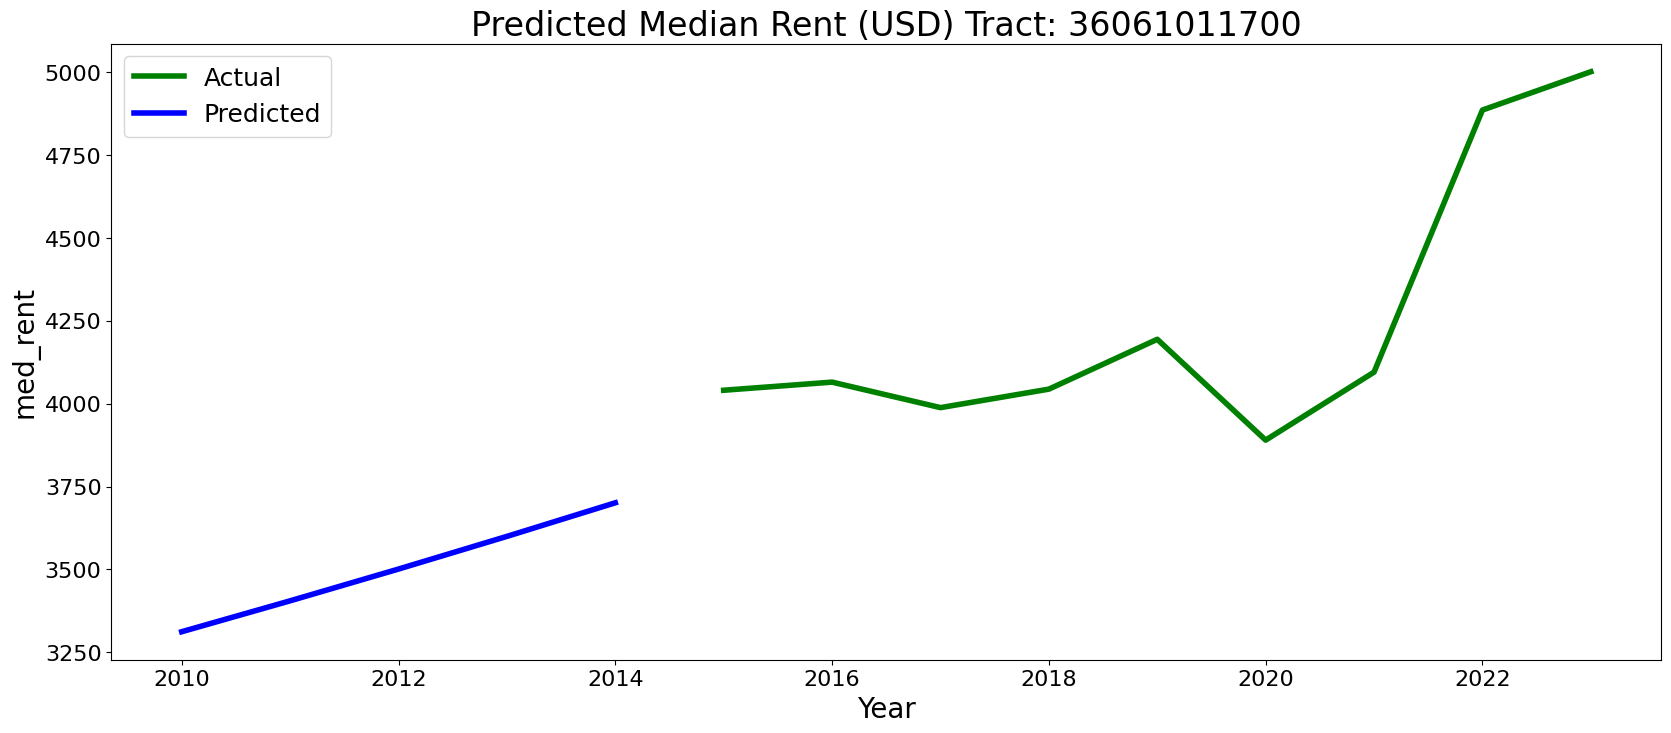

In [88]:
dff['Category'] = np.where(dff['year'].astype(str).isin(['2010','2011','2012','2013','2014']),'Predicted','Actual')

to_plot = dff[dff.GEOID=='36061011700']
lineplot(to_plot, ['med_rent'], title="Predicted Median Rent (USD) Tract: 36061011700" )